# Text Classification with LSTM

<img src="https://github.com/ckenlam/Sentiment-Analysis-with-LSTM/blob/master/sentiment.jpg?raw=true" width="700">

Even though the use of a pre-trained word embedding matrix was proven to deliver very good results with a very small dataset, the model that I previously built did not take word sequences into consideration. In this experiment, I would like to explore how RNN-LSTM can be used to learn sequences and produce better models for text classification.  

## Loading the libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import re 
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
#the following is the make sure the input will be of same length
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


## Reading the Data

For this experiment, I will be using a dataset of tweets related to the major airlines.  

In [2]:
dataset = pd.read_csv('Tweets.csv')
dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset.head(10)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,569190811113525249,negative,1.0000,Flight Attendant Complaints,0.6667,Delta,NaN,kaitlynrosati,NaN,0,@JetBlue serious attitude. I was in the fault ...,NaN,2015-02-21 09:43:59 -0800,CONCRETE JUNGLE,Pacific Time (US & Canada)
1,569693689766907904,neutral,1.0000,NaN,NaN,United,NaN,nottooshABBYYYY,NaN,0,@united What are the chances of my flight to E...,NaN,2015-02-22 19:02:14 -0800,NaN,Atlantic Time (Canada)
2,569956624036540416,negative,1.0000,Late Flight,0.6738,Southwest,NaN,jlgustafson1,NaN,0,@SouthwestAir will continue to be my airline o...,NaN,2015-02-23 12:27:03 -0800,DEN,NaN
3,568158656522539008,negative,0.6735,Can't Tell,0.6735,United,NaN,qlyss8,NaN,0,@united feeling poor on the church-mouse level...,NaN,2015-02-18 13:22:34 -0800,"Texas, USA",Mountain Time (US & Canada)
4,567753757702647810,positive,1.0000,NaN,NaN,Virgin America,NaN,Perceptions,NaN,0,@VirginAmerica really wish you'd fly out of #F...,NaN,2015-02-17 10:33:38 -0800,"Fargo, ND ( & Tucson, AZ)",Central Time (US & Canada)
5,569989034501500928,negative,1.0000,Customer Service Issue,1.0000,Virgin America,NaN,rachie1126,NaN,0,@VirginAmerica I called a 3-4 weeks ago about ...,NaN,2015-02-23 14:35:50 -0800,"New York, NY",Eastern Time (US & Canada)
6,570246895530078208,neutral,0.6779,NaN,0.0000,American,NaN,LSNorwich,NaN,0,@AmericanAir and then wanted to change it to B...,NaN,2015-02-24 07:40:29 -0800,NaN,London
7,569921646057926656,negative,1.0000,Customer Service Issue,1.0000,US Airways,NaN,rapidtravelchai,NaN,0,@USAirways any way to get your call center to ...,NaN,2015-02-23 10:08:03 -0800,NaN,Eastern Time (US & Canada)
8,570214660638511104,positive,0.6632,NaN,0.0000,United,NaN,BouleChitte,NaN,0,@united private jet would have been cool! Do d...,NaN,2015-02-24 05:32:23 -0800,NaN,NaN
9,569661596898709504,negative,1.0000,Late Flight,0.6677,American,NaN,thebrainlair,NaN,0,@AmericanAir I cannot believe how long flight ...,NaN,2015-02-22 16:54:43 -0800,Indiana,Eastern Time (US & Canada)


In [3]:
dataset = dataset[['airline_sentiment','text']]

In [4]:
dataset.shape

(14640, 2)

In [5]:
dataset.head(5)

,airline_sentiment,text
0,negative,@JetBlue serious attitude. I was in the fault ...
1,neutral,@united What are the chances of my flight to E...
2,negative,@SouthwestAir will continue to be my airline o...
3,negative,@united feeling poor on the church-mouse level...
4,positive,@VirginAmerica really wish you'd fly out of #F...


## Data Visualization

In [6]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_palette('BrBG_r',3)

/Users/kenlam/anaconda/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/kenlam/anaconda/envs/py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


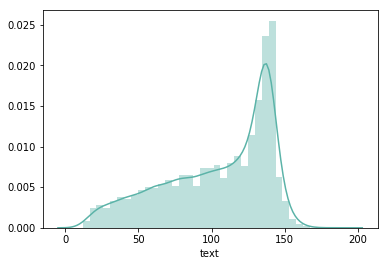

In [7]:
sns.distplot(dataset['text'].str.len())

/Users/kenlam/anaconda/envs/py3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


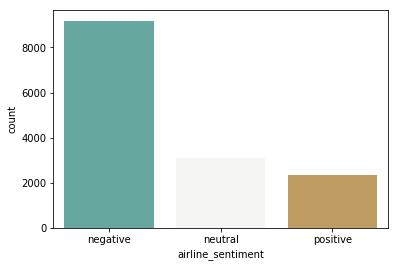

In [8]:
sns.countplot(dataset['airline_sentiment'])

In [9]:
dataset.airline_sentiment.value_counts(normalize=True)

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64

## Data Preprocessing

In [10]:
dataset['text']=dataset['text'].apply(lambda x:x.lower())
dataset['text']=dataset['text'].apply(lambda x:re.sub('[^a-zA-Z0-9\s]',"",x))
dataset['text'].head()

0    jetblue serious attitude i was in the fault fo...
1    united what are the chances of my flight to ew...
2    southwestair will continue to be my airline of...
3    united feeling poor on the churchmouse level h...
4    virginamerica really wish youd fly out of farg...
Name: text, dtype: object

In [11]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(dataset['text'].values)
X = tokenizer.texts_to_sequences(dataset['text'].values)
X = pad_sequences(X)
X[:7]

array([[   0,    0,    0,    0,    0,    0,    0,   17, 1161,  883,    3,
          23,   15,    2,  701,    7,  757,    4,  955,   31,  190,  185,
         136,  837,   11,  357,   86,   11,    8,  263,  185, 3092,   19],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    5,   57,   35,    2, 1427,
          18,   11,    8,    1,  436,   33, 1508,  195,   37,  178,  131],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          16,   49, 1256,    1,   32,   11,  100,   18,  928,    5,  446,
         563,  170,  119,  113, 1162,  231,  267,   10,  139,   80,  593],
       [   0,    0,    0,    0,    0,    0,    0,    0,    5, 1428,  405,
           9,    2, 1257,  141, 2223, 1204,   14,  464,    1,  125,    4,
        4598,  956, 2455,   48,   24,    4, 4598,  956,   31, 3665,  564],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,   

In [12]:
MAX_SEQUENCE_LENGTH = len(X[0])

## Training the model

In [13]:
from tqdm import tqdm

I'll be using the pre-trained GloVe (Global Vectors for Word Representation) from the following [link](http://nlp.stanford.edu/data/glove.840B.300d.zip).

In [14]:
embeddings_index = {}
f = open('glove.840B.300d.txt', encoding="utf8")
for line in tqdm(f):
    values = line.split()
    word = values[0]
    try:
       coefs = np.asarray(values[1:], dtype='float32')
       embeddings_index[word] = coefs
    except ValueError:
       pass
f.close()

2196017it [02:40, 13677.22it/s]


In [15]:
word_index = tokenizer.word_index
print('There are %s words in our word index matrix' %(len(word_index)))

There are 16691 words in our word index matrix


In [16]:
EMBEDDING_DIM=len(list(embeddings_index.items())[0][1])
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

### Model 1: Train your own embedding layer + 2 LSTM layers

In this case, the weights in the embedding layer are assigned randomly and will be trained/updated during the training and backpropagation,.

In [17]:
model1 = Sequential()
model1.add(Embedding(5000,256,input_length=X.shape[1]))
model1.add(Dropout(0.3))
model1.add(LSTM(300, return_sequences=True,dropout=0.3, recurrent_dropout=0.2))
model1.add(LSTM(300, dropout=0.3, recurrent_dropout=0.2))
model1.add(Dense(3,activation='softmax'))

In [18]:
model1.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 33, 256)           1280000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 33, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 33, 300)           668400    
_________________________________________________________________
lstm_2 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 903       
Total params: 2,670,503
Trainable params: 2,670,503
Non-trainable params: 0
_________________________________________________________________


### Model 2: Use pre-trained GloVe embedding layer + 2 LSTM layers

In this case, the embedding weights are initialized with the pre-trained GloVe embeddings - in an attempt to put the network in a proper state prior to training (i.e. trying to avoid falling into some local minima). The weights can be updated during training, but not recommended unless enough training data is available.

[reference](https://github.com/keras-team/keras/issues/3110)

In [20]:
model2 = Sequential()
model2.add(Embedding(len(word_index) + 1,EMBEDDING_DIM,input_length=MAX_SEQUENCE_LENGTH,weights=[embedding_matrix],trainable=False))
model2.add(Dropout(0.3))
model2.add(LSTM(300, return_sequences=True,dropout=0.3, recurrent_dropout=0.2))
model2.add(LSTM(300, return_sequences=True,dropout=0.3, recurrent_dropout=0.2))
model2.add(LSTM(300, dropout=0.3, recurrent_dropout=0.2))
model2.add(Dense(3,activation='softmax'))

In [21]:
model2.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 33, 300)           5007600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 33, 300)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 33, 300)           721200    
_________________________________________________________________
lstm_4 (LSTM)                (None, 33, 300)           721200    
_________________________________________________________________
lstm_5 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 903       
Total params: 7,172,103
Trainable params: 2,164,503
Non-trainable params: 5,007,600
__________________________________________________________

### Model 3: Use pre-trained GloVe embedding layer + 3 LSTM layers

In [23]:
model3 = Sequential()
model3.add(Embedding(len(word_index) + 1,EMBEDDING_DIM,input_length=MAX_SEQUENCE_LENGTH,weights=[embedding_matrix],trainable=False))
model3.add(Dropout(0.3))
model3.add(LSTM(300, return_sequences=True,dropout=0.3, recurrent_dropout=0.2))
model3.add(LSTM(300, return_sequences=True,dropout=0.3, recurrent_dropout=0.2))
model3.add(LSTM(300, dropout=0.3, recurrent_dropout=0.2))
model3.add(Dense(3,activation='softmax'))

In [24]:
model3.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 33, 300)           5007600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 33, 300)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 33, 300)           721200    
_________________________________________________________________
lstm_7 (LSTM)                (None, 33, 300)           721200    
_________________________________________________________________
lstm_8 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 903       
Total params: 7,172,103
Trainable params: 2,164,503
Non-trainable params: 5,007,600
__________________________________________________________

### Model 4: Use pre-trained GloVe embedding layer + 2 Bidirectional LSTM layers

In [26]:
from keras.layers import Bidirectional
model4 = Sequential()
model4.add(Embedding(len(word_index) + 1,EMBEDDING_DIM,input_length=MAX_SEQUENCE_LENGTH,weights=[embedding_matrix],trainable=False))
model4.add(Dropout(0.3))
model4.add(Bidirectional(LSTM(300, return_sequences=True,dropout=0.3, recurrent_dropout=0.2)))
model4.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.2)))
model4.add(Dense(3,activation='softmax'))

In [27]:
model4.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 33, 300)           5007600   
_________________________________________________________________
dropout_4 (Dropout)          (None, 33, 300)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 33, 600)           1442400   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 600)               2162400   
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 1803      
Total params: 8,614,203
Trainable params: 3,606,603
Non-trainable params: 5,007,600
_________________________________________________________________


### Model 5: Use pre-trained GloVe embedding layer + 3 Bidirectional LSTM layers

In [29]:
model5 = Sequential()
model5.add(Embedding(len(word_index) + 1,EMBEDDING_DIM,input_length=MAX_SEQUENCE_LENGTH,weights=[embedding_matrix],trainable=False))
model5.add(Dropout(0.3))
model5.add(LSTM(300, return_sequences=True,dropout=0.3, recurrent_dropout=0.2))
model5.add(LSTM(300, return_sequences=True,dropout=0.3, recurrent_dropout=0.2))
model5.add(LSTM(300, return_sequences=True,dropout=0.3, recurrent_dropout=0.2))
model5.add(LSTM(300, dropout=0.3, recurrent_dropout=0.2))
model5.add(Dense(3,activation='softmax'))

In [30]:
model5.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 33, 300)           5007600   
_________________________________________________________________
dropout_5 (Dropout)          (None, 33, 300)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 33, 300)           721200    
_________________________________________________________________
lstm_12 (LSTM)               (None, 33, 300)           721200    
_________________________________________________________________
lstm_13 (LSTM)               (None, 33, 300)           721200    
_________________________________________________________________
lstm_14 (LSTM)               (None, 300)               721200    
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 903       
Total para

### Model 6: Use pre-trained GloVe embedding layer + 3 LSTM layers + Higher Dropout rate + More Epochs

In [82]:
model6 = Sequential()
model6.add(Embedding(len(word_index) + 1,EMBEDDING_DIM,input_length=MAX_SEQUENCE_LENGTH,weights=[embedding_matrix],trainable=False))
model6.add(Dropout(0.6))
model6.add(LSTM(300, return_sequences=True,dropout=0.6, recurrent_dropout=0.6))
model6.add(LSTM(300, return_sequences=True,dropout=0.6, recurrent_dropout=0.6))
model6.add(LSTM(300, dropout=0.6, recurrent_dropout=0.6))
model6.add(Dense(3,activation='softmax'))

In [83]:
model6.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [84]:
model6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 33, 300)           5007600   
_________________________________________________________________
dropout_6 (Dropout)          (None, 33, 300)           0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 33, 300)           721200    
_________________________________________________________________
lstm_16 (LSTM)               (None, 33, 300)           721200    
_________________________________________________________________
lstm_17 (LSTM)               (None, 300)               721200    
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 903       
Total params: 7,172,103
Trainable params: 2,164,503
Non-trainable params: 5,007,600
__________________________________________________________

### Model 7: Use pre-trained GloVe embedding layer + 2 Bidirectional LSTM layers + Higher Dropout Rate + More Epochs

In [95]:
from keras.layers import Bidirectional
model7 = Sequential()
model7.add(Embedding(len(word_index) + 1,EMBEDDING_DIM,input_length=MAX_SEQUENCE_LENGTH,weights=[embedding_matrix],trainable=False))
model7.add(Dropout(0.6))
model7.add(Bidirectional(LSTM(300, return_sequences=True,dropout=0.6, recurrent_dropout=0.6)))
model7.add(Bidirectional(LSTM(300, dropout=0.6, recurrent_dropout=0.6)))
model7.add(Dense(3,activation='softmax'))

In [96]:
model7.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [97]:
model7.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 33, 300)           5007600   
_________________________________________________________________
dropout_7 (Dropout)          (None, 33, 300)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 33, 600)           1442400   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 600)               2162400   
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 1803      
Total params: 8,614,203
Trainable params: 3,606,603
Non-trainable params: 5,007,600
_________________________________________________________________


### Training of All Models

In [32]:
from keras.callbacks import History 
from keras.callbacks import EarlyStopping

In [33]:
y = pd.get_dummies(dataset['airline_sentiment']).values

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [35]:
batch_size = 32
epochs = 10

In [49]:
print('Training model#1')
history1 = model1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose = 1, validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
model1.save('sentiment_model1.h5')
print('model#1 trained!')

Training model#1
Train on 10540 samples, validate on 1172 samples
Epoch 1/10
10540/10540 [==============================] - 87s 8ms/step - loss: 0.1257 - acc: 0.9579 - val_loss: 0.7527 - val_acc: 0.7969
Epoch 2/10
10540/10540 [==============================] - 83s 8ms/step - loss: 0.0986 - acc: 0.9661 - val_loss: 0.8221 - val_acc: 0.7739
Epoch 3/10
10540/10540 [==============================] - 91s 9ms/step - loss: 0.0775 - acc: 0.9750 - val_loss: 0.9444 - val_acc: 0.7824
Epoch 4/10
10540/10540 [==============================] - 99s 9ms/step - loss: 0.0661 - acc: 0.9778 - val_loss: 1.0955 - val_acc: 0.7799
model#1 trained!


In [54]:
print('Training model#2')
history2 = model2.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose = 1, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
model2.save('sentiment_model2.h5')
print('model#2 trained!')

Training model#2
Train on 10540 samples, validate on 1172 samples
Epoch 1/10
10540/10540 [==============================] - 124s 12ms/step - loss: 0.5705 - acc: 0.7715 - val_loss: 0.5326 - val_acc: 0.7799
Epoch 2/10
10540/10540 [==============================] - 121s 11ms/step - loss: 0.5028 - acc: 0.7998 - val_loss: 0.5362 - val_acc: 0.7901
Epoch 3/10
10540/10540 [==============================] - 117s 11ms/step - loss: 0.4738 - acc: 0.8105 - val_loss: 0.5579 - val_acc: 0.7867
Epoch 4/10
10540/10540 [==============================] - 115s 11ms/step - loss: 0.4178 - acc: 0.8340 - val_loss: 0.5453 - val_acc: 0.7875
model#2 trained!


In [55]:
print('Training model#3')
history3 =model3.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose = 1, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
model3.save('sentiment_model3.h5')
print('model#3 trained!')

Training model#3
Train on 10540 samples, validate on 1172 samples
Epoch 1/10
10540/10540 [==============================] - 132s 13ms/step - loss: 0.3758 - acc: 0.8527 - val_loss: 0.4852 - val_acc: 0.8166
Epoch 2/10
10540/10540 [==============================] - 125s 12ms/step - loss: 0.3456 - acc: 0.8657 - val_loss: 0.5592 - val_acc: 0.8114
Epoch 3/10
10540/10540 [==============================] - 129s 12ms/step - loss: 0.3275 - acc: 0.8717 - val_loss: 0.5243 - val_acc: 0.8080
Epoch 4/10
10540/10540 [==============================] - 121s 11ms/step - loss: 0.2921 - acc: 0.8894 - val_loss: 0.5546 - val_acc: 0.8166
model#3 trained!


In [56]:
print('Training model#4')
history4 = model4.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose = 1, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
model4.save('sentiment_model4.h5')
print('model#4 trained!')

Training model#4
Train on 10540 samples, validate on 1172 samples
Epoch 1/10
10540/10540 [==============================] - 215s 20ms/step - loss: 0.3799 - acc: 0.8493 - val_loss: 0.5375 - val_acc: 0.8038
Epoch 2/10
10540/10540 [==============================] - 216s 20ms/step - loss: 0.3556 - acc: 0.8605 - val_loss: 0.5213 - val_acc: 0.8089
Epoch 3/10
10540/10540 [==============================] - 208s 20ms/step - loss: 0.3328 - acc: 0.8663 - val_loss: 0.5355 - val_acc: 0.8029
Epoch 4/10
10540/10540 [==============================] - 188s 18ms/step - loss: 0.2905 - acc: 0.8856 - val_loss: 0.5988 - val_acc: 0.8080
Epoch 5/10
10540/10540 [==============================] - 189s 18ms/step - loss: 0.2720 - acc: 0.8897 - val_loss: 0.5773 - val_acc: 0.7935
model#4 trained!


In [57]:
print('Training model#5')
history5 =model5.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose = 1, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
model5.save('sentiment_model5.h5')
print('model#5 trained!')

Training model#5
Train on 10540 samples, validate on 1172 samples
Epoch 1/10
10540/10540 [==============================] - 155s 15ms/step - loss: 0.3909 - acc: 0.8470 - val_loss: 0.5314 - val_acc: 0.8097
Epoch 2/10
10540/10540 [==============================] - 149s 14ms/step - loss: 0.3735 - acc: 0.8545 - val_loss: 0.5726 - val_acc: 0.8063
Epoch 3/10
10540/10540 [==============================] - 149s 14ms/step - loss: 0.3480 - acc: 0.8689 - val_loss: 0.5199 - val_acc: 0.8097
Epoch 4/10
10540/10540 [==============================] - 149s 14ms/step - loss: 0.3236 - acc: 0.8754 - val_loss: 0.5998 - val_acc: 0.7961
Epoch 5/10
10540/10540 [==============================] - 149s 14ms/step - loss: 0.3001 - acc: 0.8844 - val_loss: 0.5706 - val_acc: 0.8080
Epoch 6/10
10540/10540 [==============================] - 149s 14ms/step - loss: 0.2882 - acc: 0.8926 - val_loss: 0.5773 - val_acc: 0.7995
model#5 trained!


In [91]:
print('Training model#6')
history6 =model6.fit(X_train, y_train, epochs=20, batch_size=batch_size, verbose = 1, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
model6.save('sentiment_model6.h5')
print('model#6 trained!')

Training model#6
Train on 10540 samples, validate on 1172 samples
Epoch 1/20
10540/10540 [==============================] - 123s 12ms/step - loss: 0.5741 - acc: 0.7721 - val_loss: 0.5594 - val_acc: 0.7773
Epoch 2/20
10540/10540 [==============================] - 123s 12ms/step - loss: 0.5704 - acc: 0.7733 - val_loss: 0.5421 - val_acc: 0.7824
Epoch 3/20
10540/10540 [==============================] - 125s 12ms/step - loss: 0.5608 - acc: 0.7801 - val_loss: 0.5326 - val_acc: 0.7935
Epoch 4/20
10540/10540 [==============================] - 118s 11ms/step - loss: 0.5505 - acc: 0.7808 - val_loss: 0.5286 - val_acc: 0.7918
Epoch 5/20
10540/10540 [==============================] - 115s 11ms/step - loss: 0.5512 - acc: 0.7765 - val_loss: 0.5313 - val_acc: 0.7884
Epoch 6/20
10540/10540 [==============================] - 116s 11ms/step - loss: 0.5539 - acc: 0.7768 - val_loss: 0.5290 - val_acc: 0.8020
Epoch 7/20
10540/10540 [==============================] - 113s 11ms/step - loss: 0.5501 - acc: 0.780

In [98]:
print('Training model#7')
history7 =model7.fit(X_train, y_train, epochs=20, batch_size=batch_size, verbose = 1, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
model7.save('sentiment_model7.h5')
print('model#7 trained!')

Training model#7
Train on 10540 samples, validate on 1172 samples
Epoch 1/20
10540/10540 [==============================] - 213s 20ms/step - loss: 0.7540 - acc: 0.6910 - val_loss: 0.6682 - val_acc: 0.7176
Epoch 2/20
10540/10540 [==============================] - 186s 18ms/step - loss: 0.6725 - acc: 0.7242 - val_loss: 0.6163 - val_acc: 0.7457
Epoch 3/20
10540/10540 [==============================] - 185s 18ms/step - loss: 0.6470 - acc: 0.7380 - val_loss: 0.6195 - val_acc: 0.7619
Epoch 4/20
10540/10540 [==============================] - 187s 18ms/step - loss: 0.6230 - acc: 0.7492 - val_loss: 0.6034 - val_acc: 0.7543
Epoch 5/20
10540/10540 [==============================] - 186s 18ms/step - loss: 0.6120 - acc: 0.7492 - val_loss: 0.5846 - val_acc: 0.7619
Epoch 6/20
10540/10540 [==============================] - 186s 18ms/step - loss: 0.5903 - acc: 0.7617 - val_loss: 0.5510 - val_acc: 0.7807
Epoch 7/20
10540/10540 [==============================] - 186s 18ms/step - loss: 0.5788 - acc: 0.765

## Evaluation of the Models 

In [235]:
#model1 =load_model('sentiment_model1.h5')
#model2 =load_model('sentiment_model2.h5')
#model3 =load_model('sentiment_model3.h5')
#model4 =load_model('sentiment_model4.h5')
#model5 =load_model('sentiment_model5.h5')
#model6 =load_model('sentiment_model6.h5')
#model7 =load_model('sentiment_model7.h5')

In [58]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import keras.backend as K

In [99]:
predict_class1 = model1.predict_classes(X_test)
predict_class2 = model2.predict_classes(X_test)
predict_class3 = model3.predict_classes(X_test)
predict_class4 = model4.predict_classes(X_test)
predict_class5 = model5.predict_classes(X_test)
predict_class6 = model6.predict_classes(X_test)
predict_class7 = model7.predict_classes(X_test)
y_test_class = pd.DataFrame(y_test).idxmax(axis=1)

In [100]:
for n in range(1,8):
    print("-"*15,"Model#%s CLASSIFICATION REPORT" %(n),"-"*15)
    print(classification_report(pd.DataFrame(y_test_class), pd.DataFrame(globals()['predict_class%s' % n])))
    

--------------- Model#1 CLASSIFICATION REPORT ---------------
             precision    recall  f1-score   support

          0       0.85      0.88      0.87      1820
          1       0.58      0.62      0.60       599
          2       0.78      0.64      0.70       509

avg / total       0.79      0.78      0.78      2928

--------------- Model#2 CLASSIFICATION REPORT ---------------
             precision    recall  f1-score   support

          0       0.84      0.91      0.87      1820
          1       0.65      0.61      0.63       599
          2       0.79      0.62      0.69       509

avg / total       0.79      0.80      0.79      2928

--------------- Model#3 CLASSIFICATION REPORT ---------------
             precision    recall  f1-score   support

          0       0.85      0.93      0.89      1820
          1       0.68      0.59      0.63       599
          2       0.79      0.67      0.72       509

avg / total       0.81      0.81      0.81      2928

----------

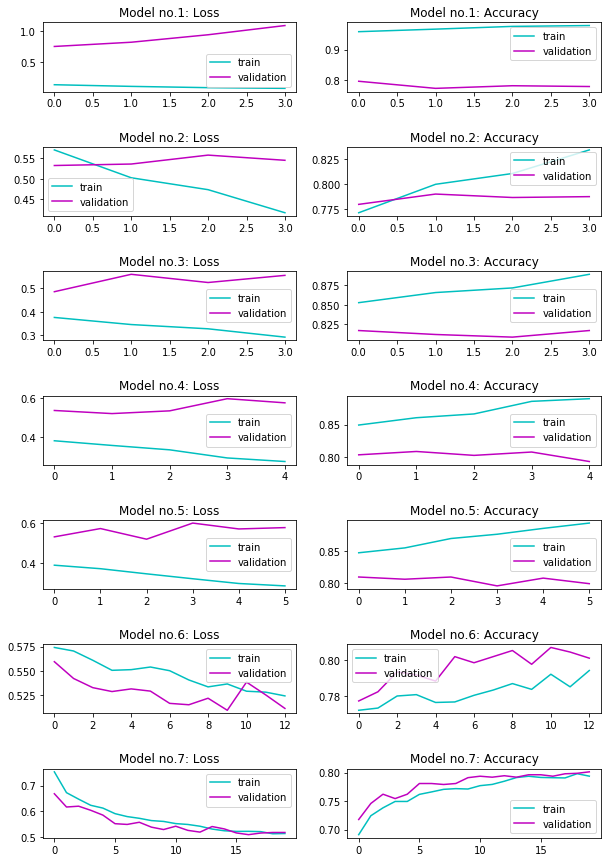

In [236]:
m = 1
plt.figure(figsize=(10,15))
plt.subplots_adjust(hspace=0.8)
for n in range(1,8):
    history = globals()['history%s' % n]
    plt.subplot(7, 2, m)
    plt.title('Model no.%s: Loss' %(n))
    plt.plot(history.history['loss'], label='train', color='c')
    plt.plot(history.history['val_loss'], label='validation',color='m')
    plt.legend()
    
    plt.subplot(7, 2, m+1)
    plt.title('Model no.%s: Accuracy' %(n))
    plt.plot(history.history['acc'], label='train', color='c')
    plt.plot(history.history['val_acc'], label='validation',color='m')
    plt.legend()
    m += 2


## Testing of the Model

Here, I will test all the models with an unseen input sentence.  

In [232]:
testing = 'The staff was very condescending and rude'

In [233]:
def data_processing(text):
    text = text.lower()
    text = re.sub('[^a-zA-Z0-9\s]',"",text)
    X_text = tokenizer.texts_to_sequences([text])
    X_text = pad_sequences(X_text, maxlen=MAX_SEQUENCE_LENGTH)
    return(X_text)

In [234]:
testing = data_processing(testing)
for n in range(1,8):
    model = globals()['model%s' % n]
    print('According to Model no.%s...' %(n))
    print('This review has a %.1f%% probability of being negative and a %.1f%% probability of being positive.' 
          %(model.predict(testing)[0][0]*100, model.predict(testing)[0][2]*100))
    if model.predict_classes(testing)[0] == 0:
        print('Model no.%s classified it as a negative review.' %(n))
    elif model.predict_classes(testing)[0] == 1:
        print('Model no.%s classified it as a neutral review.' %(n))
    else:
        print('Model no.%s classified it as a positive review.' %(n))
    print('\n')

According to Model no.1...
This review has a 11.6% probability of being negative and a 53.4% probability of being positive.
Model no.1 classified it as a positive review.


According to Model no.2...
This review has a 19.5% probability of being negative and a 60.6% probability of being positive.
Model no.2 classified it as a positive review.


According to Model no.3...
This review has a 99.5% probability of being negative and a 0.4% probability of being positive.
Model no.3 classified it as a negative review.


According to Model no.4...
This review has a 69.3% probability of being negative and a 8.0% probability of being positive.
Model no.4 classified it as a negative review.


According to Model no.5...
This review has a 97.9% probability of being negative and a 1.9% probability of being positive.
Model no.5 classified it as a negative review.


According to Model no.6...
This review has a 87.1% probability of being negative and a 11.1% probability of being positive.
Model no.6 cla

## Conclusion

- **Model no.1** is the only model that did not use a pre-trained word embedding and its performance was by far the worst; this proves once again how beneficial it is to initialize the weights with a pre-trained word embedding.
- The steady increase of validation loss observed in **Model no.1 to no.5** is a clear indication of overfitting. Increasing the number of hidden units and/or layers may lead to overfitting because it will make it easier for the neural network to memorize the training set, that is to learn a function that perfectly separates the training set but that does not generalize to unseen data.
- Having noticed the overfitting issue in Model no1 to no.5, I increased the dropout rate in each layer for **Model no.6 and Model no.7**. As you can see from the validation losses, increasing dropout rate is a clear improvement over the previous models. 
- **Model no.7 is the clear winner** here because the plot of its validation loss decreases to a point of stability and has a small gap with the training loss.
- Increasing the dataset will likely improve the results as we were dealing with a relatively small sample of 14640 tweets. 
- One can also consider using weight regularization as an alternative approach to reduce the overfitting of the model on the training data. 